In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import missingno as msno

In [2]:
df_data = pd.read_csv('dataset_mood_smartphone.csv')

In [3]:
# Drop all NA values
df_data = df_data.dropna(0,'any',None,None,False)

In [4]:
df_data.drop('Unnamed: 0', 1,inplace=True)

In [5]:
# Lists with unique variables and ids
all_variables = list(df_data.variable.unique())
all_ids = list(df_data.id.unique())

In [6]:
# Create usable time columns
df_data[['date','time']] = df_data.time.str.split(" ",expand=True)
start_date = df_data.date.min()
end_date = df_data.date.max()
all_dates = pd.date_range(start_date, end_date)

In [7]:
# Create empty dataframe
index_id_date = pd.MultiIndex.from_product([all_ids,all_dates], names = ["Id", "Date"])
data = pd.DataFrame(np.nan,index = index_id_date,columns= all_variables)

In [8]:
count = 0
# for each id
for i in all_ids:

    # for each date
    for d in all_dates:
        d_str = d.strftime('%Y-%m-%d')

        # create df snapshot based on all unique id-date combinations
        df_snapshot = df_data[df_data['date'] == d_str][df_data['id']== i]

        # fill in values based on variable
        for var in list(df_snapshot.variable.unique()):

            # compute daily mean for x variables
            if var in ['mood', 'circumplex.arousal', 'circumplex.valence']:
                var_mean = np.mean(df_snapshot[df_snapshot['variable']== var]['value'])
                data[var][count] = var_mean

            # compute sum for z variables
            else:
                var_sum = np.sum(df_snapshot[df_snapshot['variable']== var]['value'])
                data[var][count] = var_sum
                
        count += 1

<ipython-input-8-c80dbaf752b4>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_snapshot = df_data[df_data['date'] == d_str][df_data['id']== i]


In [9]:
# add counting days variable
data['days_count'] = np.nan
count = 0
for i in all_ids:
    count_days = 0
    for d in all_dates:
        count_days +=1
        data['days_count'][count] = count_days
        count += 1

In [10]:
# EDA here
# possibly autocorrelation for mood to define lagged aggregation of features

In [11]:
#df_interpolation(data,all_variables,3)
data.describe()

,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,days_count
count,1268.000000,1268.000000,1266.000000,1188.000000,1207.000000,1338.000000,734.000000,1195.000000,1183.000000,850.000000,207.000000,193.000000,276.000000,1120.000000,988.000000,429.000000,264.000000,433.000000,113.000000,3051.00000
mean,6.990063,-0.103851,0.687112,2.241571,6027.939920,3.915546,2.449591,1416.168076,2721.389269,1199.131796,98.686865,540.841363,461.558359,176.297251,1402.970122,303.379951,162.023761,106.473192,45.468336,57.00000
std,0.736465,0.662715,0.434602,1.788124,4696.746814,3.555254,2.327730,3841.698865,2466.290266,1921.094754,155.448526,1171.180079,2128.298133,395.155057,1982.361939,720.460894,317.440513,234.074451,53.280275,32.62436
min,3.000000,-2.000000,-1.250000,0.000000,0.462000,1.000000,1.000000,-80367.930000,1.095000,1.014000,1.004000,1.010000,0.044000,2.007000,0.725000,0.080000,0.111000,1.002000,1.007000,1.00000
25%,6.600000,-0.600000,0.400000,0.934891,2423.275500,1.000000,1.000000,262.656000,867.679500,200.786500,27.139000,82.664000,17.101750,44.507750,208.440250,62.299000,22.132250,9.033000,13.111000,29.00000
50%,7.000000,0.000000,0.800000,1.965931,5026.947999,3.000000,1.000000,764.085000,2078.403000,662.026000,49.379000,209.750000,71.999000,65.393000,759.500000,143.316000,66.667000,26.402000,30.386000,57.00000
75%,7.500000,0.400000,1.000000,3.013197,8558.515500,5.000000,3.000000,1558.217000,3789.369000,1551.364500,99.850000,540.616000,271.162750,139.492750,2001.708500,284.954000,176.652250,88.629000,54.055000,85.00000
max,9.333333,2.000000,2.000000,11.535524,36204.105001,31.000000,17.000000,40323.877000,20718.749000,35937.645000,1321.104000,12996.495000,33283.021000,4335.307000,30073.421000,10548.116000,2821.547000,2257.626000,366.937000,113.00000


In [12]:
# Values of appCat.builtin < 0 are impossible, therefore we change these value(s) to NA's. 
count=0
for i in range(len(data)):
    if data['appCat.builtin'][i]<0:
        count+=1
        data['appCat.builtin'][i]=np.nan
print('Number of removed values: {}'.format(count))

Number of removed values: 1


In [13]:
# Deleting large amounts of NA in a row
# deleting groups of rows that contain "NA"s in more than/equal to 2 consecutive days for mood
# !! Argument in Report !! these timewondows wont work/will add noise when aggregating the data
for i in all_ids:
    count = 0
    deathrow = []
    
    for j in np.array(all_dates.strftime('%Y-%m-%d')):
        if np.isnan(data.loc[i,'mood'][j]):
            count += 1
            deathrow.append(j)
            if j == np.array(all_dates.strftime('%Y-%m-%d'))[-1]:
                for d in deathrow:
                    data = data.drop((i, d))
            
                deathrow = []
                count = 0   
        else:
            if count > 2:
                for d in deathrow:
                    data = data.drop((i, d))
            deathrow = []
            count = 0

In [14]:
# Combine app categories
# Because of the large amount of NAs in the feature space, it is beneficial to join the various app categories in various caregory categories
# !! Argument in Report !!

# Possiby more features can be created e.g. weekend dummy

data['appCat.professional'] = data[['appCat.office', 'appCat.finance']].sum(axis=1, skipna=True)
data['appCat.recreation'] = data[['appCat.game','appCat.entertainment','appCat.social']].sum(axis=1, skipna=True)
data['appCat.convenience'] = data[['appCat.travel','appCat.utilities','appCat.weather']].sum(axis=1, skipna=True)
data['appCat.plain_usage'] = data[['appCat.other','appCat.unknown','appCat.builtin']].sum(axis=1, skipna=True)
column_names = ['appCat.builtin','appCat.entertainment','appCat.finance','appCat.game','appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
data = data.drop(columns=column_names, axis=1)

In [15]:
# for binary varibales: replace nan with zero
data['call'] = data['call'].fillna(0)
data['sms'] = data['sms'].fillna(0)

In [16]:
# maybe no treatment of missing values needed if backwards aggregation is used
backup = data.copy()


In [17]:
backup.isna().sum()

mood                     25
circumplex.arousal       25
circumplex.valence       27
activity                119
screen                  101
call                      0
sms                       0
appCat.communication    125
days_count                0
appCat.professional       0
appCat.recreation         0
appCat.convenience        0
dtype: int64

In [18]:
# for remaining missing data - use pandas.interpolate
# !! Argument in Report why interpolate or other method to be used !!
data_pre = backup.interpolate(axis=0)

In [19]:
data_pre.isna().sum()

mood                    0
circumplex.arousal      0
circumplex.valence      0
activity                2
screen                  2
call                    0
sms                     0
appCat.communication    2
days_count              0
appCat.professional     0
appCat.recreation       0
appCat.convenience      0
dtype: int64

In [20]:
data_pre.head(10)

mood  circumplex.arousal  circumplex.valence  \
Id      Date                                                           
AS14.01 2014-02-26  6.250000               -0.25            0.750000   
        2014-02-27  6.333333                0.00            0.333333   
        2014-03-21  6.200000                0.20            0.200000   
        2014-03-22  6.400000                0.60            0.500000   
        2014-03-23  6.800000                0.20            0.800000   
        2014-03-24  6.000000                0.80            0.000000   
        2014-03-25  6.750000                0.50            0.500000   
        2014-03-26  6.600000               -0.20            0.600000   
        2014-03-27  7.000000                0.20            0.800000   
        2014-03-28  6.400000               -0.60            0.600000   

                    activity        screen  call  sms  appCat.communication  \
Id      Date                                                                  
AS14.01 2014-02-26       NaN           NaN   1.0  2.0                   NaN   
        2014-02-27       NaN           NaN   0.0  0.0                   NaN   
        2014-03-21  3.083152  17978.907000   6.0  0.0              6280.890   
        2014-03-22  3.790084   6142.161000   3.0  1.0              4962.918   
        2014-03-23  2.141117   6773.832001   0.0  0.0              5237.319   
        2014-03-24  1.895065  15047.351001  10.0  0.0              9270.629   
        2014-03-25  2.360979  21475.354999   0.0  1.0             10276.751   
        2014-03-26  2.431400  16423.801000   0.0  0.0              8988.753   
        2014-03-27  3.509234  17442.149999   2.0  1.0              6936.512   
        2014-03-28  2.296753   4923.489000   5.0  0.0               866.833   

                    days_count  appCat.professional  appCat.recreation  \
Id      Date                                                             
AS14.01 2014-02-26        10.0                0.000              0.000   
        2014-02-27        11.0                0.000              0.000   
        2014-03-21        33.0              221.750           5515.956   
        2014-03-22        34.0               21.076            532.956   
        2014-03-23        35.0               43.403            995.185   
        2014-03-24        36.0               37.116           4200.597   
        2014-03-25        37.0               43.054           1987.677   
        2014-03-26        38.0               52.331           5502.538   
        2014-03-27        39.0              224.670           1574.720   
        2014-03-28        40.0               89.166           1751.180   

                    appCat.convenience  
Id      Date                            
AS14.01 2014-02-26               0.000  
        2014-02-27               0.000  
        2014-03-21             239.751  
        2014-03-22              98.143  
        2014-03-23              72.823  
        2014-03-24              66.558  
        2014-03-25             414.042  
        2014-03-26              97.498  
        2014-03-27              58.532  
        2014-03-28             225.951

In [21]:
# Drop first two rows for remaining missing values
data_pre = data_pre[2:]

In [22]:
var_list = list(data_pre.columns)
var_list.remove('days_count')

In [23]:
var_list

['mood',
 'circumplex.arousal',
 'circumplex.valence',
 'activity',
 'screen',
 'call',
 'sms',
 'appCat.communication',
 'appCat.professional',
 'appCat.recreation',
 'appCat.convenience']

In [24]:
data_pre.reset_index(inplace=True)
data_pre.set_index(['Id','Date','days_count'],inplace=True,drop=True)

In [25]:
# normal rolling window does not work, days are dependent on ids
#df_avg_3days = data_pre.rolling(3).mean()

In [ ]:
# 2 days - compute average over days for each id sperately

variables = var_list

for var in variables:
        data_pre[str(var)+'_2dayavg'] = np.nan

for i in all_ids:
    for var in variables:
        a = data_pre.loc[i].index
        for j in np.arange(2,len(a)):
            data_pre.loc[i,str(var)+'_2dayavg'][a[j]] = (data_pre.loc[i,var][a[j-1]]+data_pre.loc[i,var][a[j-2]])/2

In [26]:
# 3 days - compute average over days for each id sperately

variables = var_list

for var in variables:
        data_pre[str(var)+'_3dayavg'] = np.nan

for i in all_ids:
    for var in variables:
        a = data_pre.loc[i].index
        for j in np.arange(3,len(a)):
            data_pre.loc[i,str(var)+'_3dayavg'][a[j]] = (data_pre.loc[i,var][a[j-1]]+data_pre.loc[i,var][a[j-2]]+data_pre.loc[i,var][a[j-3]])/3

In [ ]:
# 4 days - compute average over days for each id sperately

variables = var_list

for var in variables:
        data_pre[str(var)+'_4dayavg'] = np.nan

for i in all_ids:
    for var in variables:
        a = data_pre.loc[i].index
        for j in np.arange(4,len(a)):
            data_pre.loc[i,str(var)+'_4dayavg'][a[j]] = (data_pre.loc[i,var][a[j-1]]+data_pre.loc[i,var][a[j-2]]+data_pre.loc[i,var][a[j-3]]+data_pre.loc[i,var][a[j-4]])/4

In [ ]:
# 5 days - compute average over days for each id sperately

variables = var_list

for var in variables:
        data_pre[str(var)+'_5dayavg'] = np.nan

for i in all_ids:
    for var in variables:
        a = data_pre.loc[i].index
        for j in np.arange(5,len(a)):
            data_pre.loc[i,str(var)+'_5dayavg'][a[j]] = (data_pre.loc[i,var][a[j-1]]+data_pre.loc[i,var][a[j-2]]+data_pre.loc[i,var][a[j-3]]+data_pre.loc[i,var][a[j-4]]+data_pre.loc[i,var][a[j-5]])/5

In [27]:
# consider shift of mood over days for each id sperately

data_pre['target'] = np.nan

for i in all_ids:
        a = data_pre.loc[i].index
        for j in np.arange(1,len(a)):
            data_pre.loc[i,'target'][a[j]] = data_pre.loc[i,'mood'][a[j-1]]

In [28]:
corr_matrix = data_pre.corr()
corr_matrix['target'].sort_values(ascending=False)

mood  circumplex.arousal  circumplex.valence  \
Id      Date       days_count                                                 
AS14.01 2014-03-21 33.0        6.20            0.200000                 0.2   
        2014-03-22 34.0        6.40            0.600000                 0.5   
        2014-03-23 35.0        6.80            0.200000                 0.8   
        2014-03-24 36.0        6.00            0.800000                 0.0   
        2014-03-25 37.0        6.75            0.500000                 0.5   
...                             ...                 ...                 ...   
AS14.33 2014-05-27 100.0       6.20           -0.600000                 0.4   
        2014-05-28 101.0       8.20            0.000000                 1.2   
        2014-05-29 102.0       7.00           -1.333333                 1.0   
        2014-05-30 103.0       6.80           -0.800000                -0.4   
        2014-05-31 104.0       7.00           -2.000000                 1.0   

                               activity        screen  call  sms  \
Id      Date       days_count                                      
AS14.01 2014-03-21 33.0        3.083152  17978.907000   6.0  0.0   
        2014-03-22 34.0        3.790084   6142.161000   3.0  1.0   
        2014-03-23 35.0        2.141117   6773.832001   0.0  0.0   
        2014-03-24 36.0        1.895065  15047.351001  10.0  0.0   
        2014-03-25 37.0        2.360979  21475.354999   0.0  1.0   
...                                 ...           ...   ...  ...   
AS14.33 2014-05-27 100.0       0.304902   4089.879001   1.0  2.0   
        2014-05-28 101.0       2.479228  14320.867998  10.0  1.0   
        2014-05-29 102.0       4.064507   3569.341000   5.0  1.0   
        2014-05-30 103.0       4.050925   9497.646999   4.0  0.0   
        2014-05-31 104.0       4.050925   9497.646999   0.0  0.0   

                               appCat.communication  appCat.professional  \
Id      Date       days_count                                              
AS14.01 2014-03-21 33.0                    6280.890              221.750   
        2014-03-22 34.0                    4962.918               21.076   
        2014-03-23 35.0                    5237.319               43.403   
        2014-03-24 36.0                    9270.629               37.116   
        2014-03-25 37.0                   10276.751               43.054   
...                                             ...                  ...   
AS14.33 2014-05-27 100.0                   2078.403                0.000   
        2014-05-28 101.0                   1936.415              357.909   
        2014-05-29 102.0                    435.105                0.000   
        2014-05-30 103.0                   1670.842                0.000   
        2014-05-31 104.0                   1670.842                0.000   

                               appCat.recreation  ...  \
Id      Date       days_count                     ...   
AS14.01 2014-03-21 33.0                 5515.956  ...   
        2014-03-22 34.0                  532.956  ...   
        2014-03-23 35.0                  995.185  ...   
        2014-03-24 36.0                 4200.597  ...   
        2014-03-25 37.0                 1987.677  ...   
...                                          ...  ...   
AS14.33 2014-05-27 100.0                2135.058  ...   
        2014-05-28 101.0                5975.917  ...   
        2014-05-29 102.0                1926.660  ...   
        2014-05-30 103.0                3426.629  ...   
        2014-05-31 104.0                   0.000  ...   

                               circumplex.valence_3dayavg  activity_3dayavg  \
Id      Date       days_count                                                 
AS14.01 2014-03-21 33.0                               NaN               NaN   
        2014-03-22 34.0                               NaN               NaN   
        2014-03-23 35.0                               NaN              

In [29]:
# remove non-avg columns
# drop nan's
data_post = data_pre.iloc[:,11:22]
data_post['target'] = data_pre['target']
data_post.dropna(inplace=True)
data_post.head(10)

<ipython-input-29-8f4083a7c449>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_post.dropna(inplace=True)


mood_3dayavg  circumplex.arousal_3dayavg  \
Id      Date       days_count                                             
AS14.01 2014-03-24 36.0            6.466667                    0.333333   
        2014-03-25 37.0            6.400000                    0.533333   
        2014-03-26 38.0            6.516667                    0.500000   
        2014-03-27 39.0            6.450000                    0.366667   
        2014-03-28 40.0            6.783333                    0.166667   
        2014-03-29 41.0            6.666667                   -0.200000   
        2014-03-30 42.0            7.133333                   -0.066667   
        2014-03-31 43.0            7.300000                   -0.300000   
        2014-04-01 44.0            7.633333                   -0.100000   
        2014-04-02 45.0            6.966667                   -0.100000   

                               circumplex.valence_3dayavg  activity_3dayavg  \
Id      Date       days_count                                                 
AS14.01 2014-03-24 36.0                          0.500000          3.004784   
        2014-03-25 37.0                          0.433333          2.608755   
        2014-03-26 38.0                          0.433333          2.132387   
        2014-03-27 39.0                          0.366667          2.229148   
        2014-03-28 40.0                          0.633333          2.767204   
        2014-03-29 41.0                          0.666667          2.745795   
        2014-03-30 42.0                          0.800000          2.480951   
        2014-03-31 43.0                          0.783333          1.540307   
        2014-04-01 44.0                          0.783333          1.338767   
        2014-04-02 45.0                          0.450000          1.740690   

                               screen_3dayavg  call_3dayavg  sms_3dayavg  \
Id      Date       days_count                                              
AS14.01 2014-03-24 36.0          10298.300000      3.000000     0.333333   
        2014-03-25 37.0           9321.114667      4.333333     0.333333   
        2014-03-26 38.0          14432.179334      3.333333     0.333333   
        2014-03-27 39.0          17648.835667      3.333333     0.333333   
        2014-03-28 40.0          18447.102000      0.666667     0.666667   
        2014-03-29 41.0          12929.813333      2.333333     0.333333   
        2014-03-30 42.0          10229.420333      3.666667     0.666667   
        2014-03-31 43.0           5923.108333      3.000000     0.333333   
        2014-04-01 44.0           8227.556667      3.333333     0.333333   
        2014-04-02 45.0          11177.984668      2.333333     0.000000   

                               appCat.communication_3dayavg  \
Id      Date       days_count                                 
AS14.01 2014-03-24 36.0                         5493.709000   
        2014-03-25 37.0                         6490.288667   
        2014-03-26 38.0                         8261.566333   
        2014-03-27 39.0                         9512.044333   
        2014-03-28 40.0                         8734.005333   
        2014-03-29 41.0                         5597.366000   
        2014-03-30 42.0                         3508.012333   
        2014-03-31 43.0                         1628.676667   
        2014-04-01 44.0                         3117.278000   
        2014-04-02 45.0                         4242.222667   

                               appCat.professional_3dayavg  \
Id      Date       days_count                                
AS14.01 2014-03-24 36.0                          95.409667   
        2014-03-25 37.0                          33.865000   
        2014-03-26 38.0                          41.191000   
        2014-03-27 39.0                          44.167000   
        2014-03-28 40.0                         106.685000   
        2014-03-29 41.0                         122.055667   
        2014-03

In [30]:
# Data preparations for model training
# - standardize/normalize
# - check for linearity
# - consider special requirements for arima (e.g.stationarity) -> temporal data

In [31]:
# Standardize input features (not target)
minmaxscaler = MinMaxScaler()
df_features = minmaxscaler.fit_transform(data_post.iloc[:,:11])
df_features = pd.DataFrame(data=df_features, columns = data_post.iloc[:,:11].columns)

<AxesSubplot:>

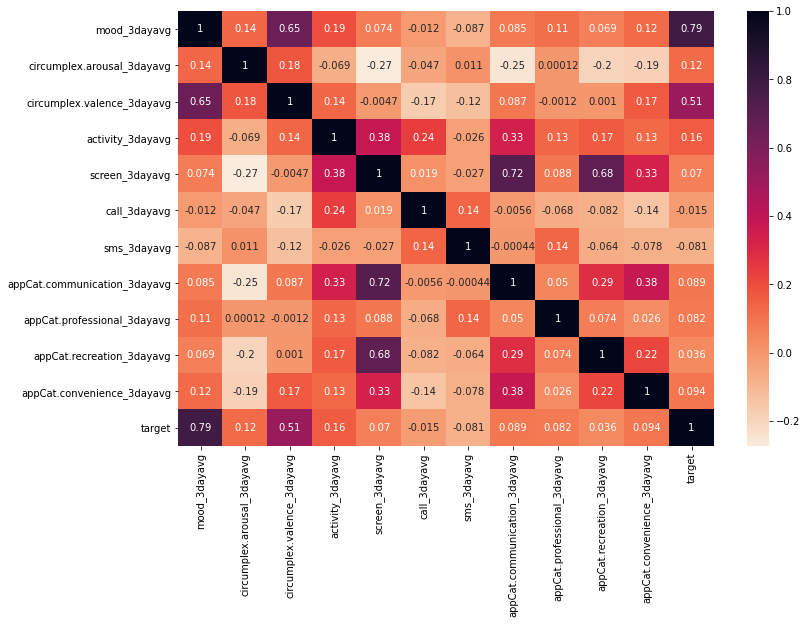

In [32]:
# !! Argument in Report !! which features are selected 
# -correlation approach
# -feature selection apporach (forward/backward)

plt.figure(figsize=(12, 8))
cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(data_post.corr(), annot=True, cmap=cmap)

In [ ]:
# maybe drop columns in case of correlation near zero
#df_features.drop(columns=['appCat.convenience_2dayavg', 'call_2dayavg'], inplace=True)

### Ramdom Forest
Training

In [33]:
# Grid search can be added
# Feature importance can be added
df_features

In [ ]:
stop xx

In [34]:
X = df_features
y = data_post['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

In [35]:
rf = RandomForestRegressor(n_estimators = 1000, max_depth=40,min_samples_leaf=4,min_samples_split=2,bootstrap=True, random_state = 12)
rf.fit(X_train, y_train)
y_train_pred=rf.predict(X_train)
y_test_pred=rf.predict(X_test)
print('MAE train:', metrics.mean_absolute_error(y_train,y_train_pred))
print('MAE test:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE train:', metrics.mean_squared_error(y_train,y_train_pred))
print('MSE test:', metrics.mean_squared_error(y_test,y_test_pred))

MAE train: 0.21840229158182115
MAE test: 0.33475443008778444
MSE train: 0.0915529640538116
MSE test: 0.20483378528630078


In [36]:
data_post['target'].describe()

count    1210.000000
mean        6.990083
std         0.729150
min         3.000000
25%         6.600000
50%         7.000000
75%         7.500000
max         9.333333
Name: target, dtype: float64

In [37]:
# MAE is lower than standard deviation of target, that's good ?

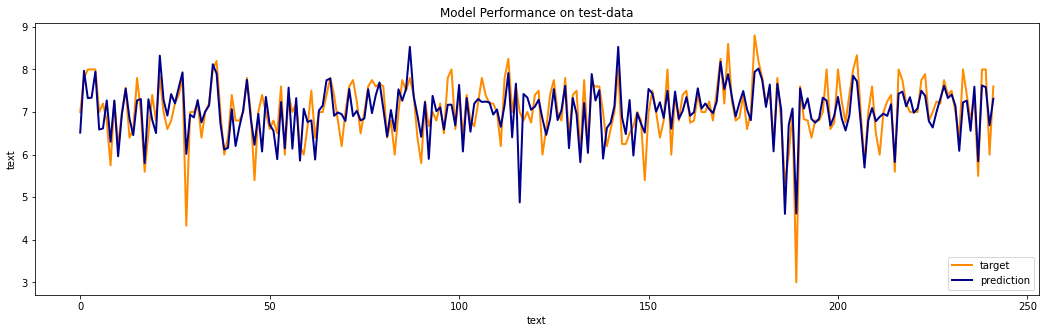

In [38]:
plt.figure(figsize = (18, 5))
plt.plot(np.array(y_test),
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_test_pred),
        color='darkblue',
        linewidth=2,
        label = 'prediction')
plt.xlabel('text')
plt.ylabel('text')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data')
plt.show()

## ARIMA
Check Stationarity

In [208]:
check_mood = pd.DataFrame(data_pre.iloc[:,0])
check_mood.reset_index(inplace=True)

In [207]:
# choose ids with many dates and values available
# 27,29,31

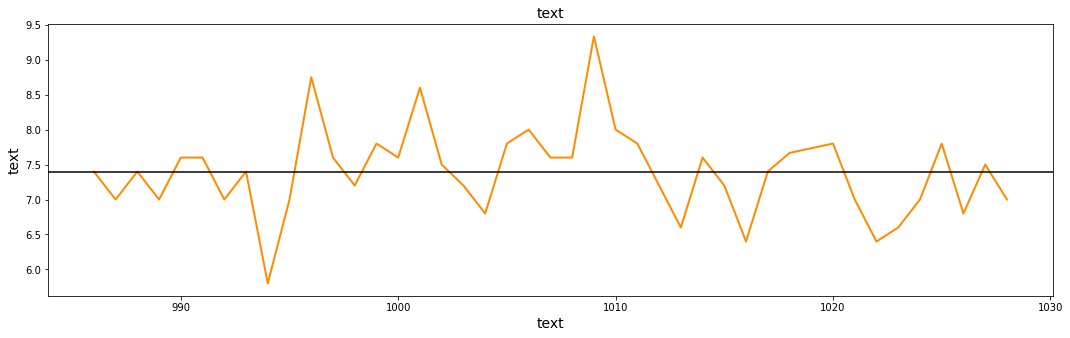

In [212]:
stat_27 = check_mood[(check_mood['Id'] == 'AS14.27')]

plt.figure(figsize = (18, 5))
plt.plot(stat_27['mood'],
        color='darkorange',
        linewidth=2,
        label = 'mood_3dayavg')

plt.axhline(stat_27['mood'].mean(), color='black')

plt.title('text',fontsize=14)
plt.xlabel('text',fontsize=14)
plt.ylabel('text',fontsize=14)
plt.show()

In [217]:
# DF test for id.27

from statsmodels.tsa.stattools import adfuller
series = stat_27['mood']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.996644
p-value: 0.000023
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


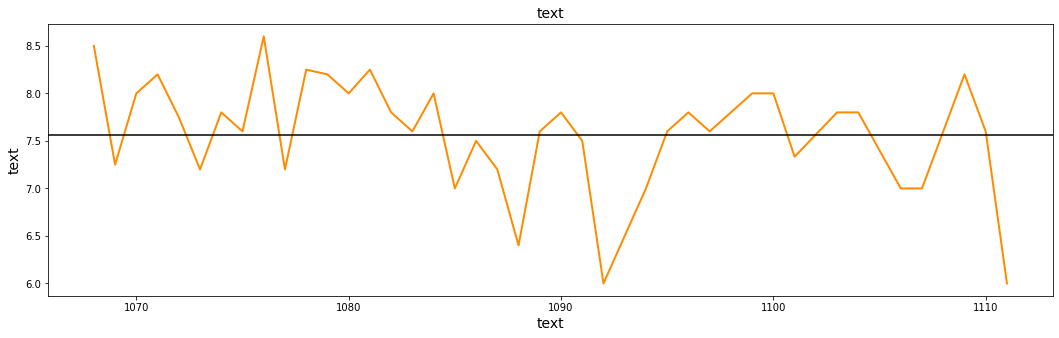

In [216]:
stat_29 = check_mood[(check_mood['Id'] == 'AS14.29')]

plt.figure(figsize = (18, 5))
plt.plot(stat_29['mood'],
        color='darkorange',
        linewidth=2,
        label = 'mood_3dayavg')

plt.axhline(stat_29['mood'].mean(), color='black')

plt.title('text',fontsize=14)
plt.xlabel('text',fontsize=14)
plt.ylabel('text',fontsize=14)
plt.show()

In [219]:
# DF test for id.29

from statsmodels.tsa.stattools import adfuller
series = stat_29['mood']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.403517
p-value: 0.010840
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


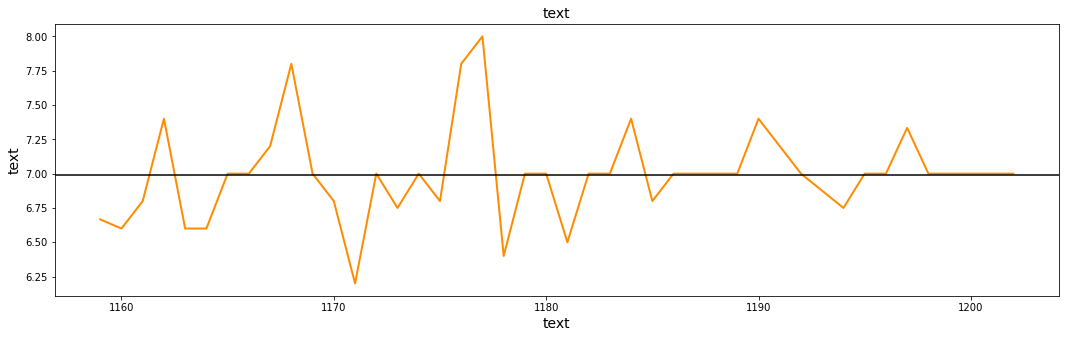

In [215]:
stat_31 = check_mood[(check_mood['Id'] == 'AS14.31')]

plt.figure(figsize = (18, 5))
plt.plot(stat_31['mood'],
        color='darkorange',
        linewidth=2,
        label = 'mood_3dayavg')

plt.axhline(stat_31['mood'].mean(), color='black')

plt.title('text',fontsize=14)
plt.xlabel('text',fontsize=14)
plt.ylabel('text',fontsize=14)
plt.show()

In [220]:
# DF test for id.31

from statsmodels.tsa.stattools import adfuller
series = stat_31['mood']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.235679
p-value: 0.000007
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


Check (Partial) Autocorrelation

In [229]:
#check_mood.set_index(['Date'],inplace=True)

In [230]:
y = check_mood.resample('D').mean()
temp_df = y.iloc[:,:]
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97 entries, 2014-03-04 to 2014-06-08
Freq: D
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   days_count  97 non-null     float64
 1   mood        97 non-null     float64
dtypes: float64(2)
memory usage: 2.3 KB


In [234]:
# checking the ac and pac over of the daily average over the whole time-series

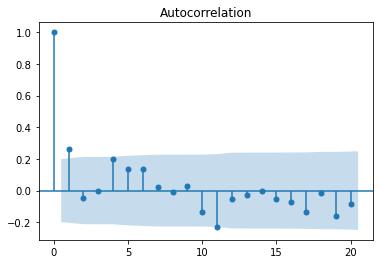

In [232]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(temp_df['mood'].values)
plt.show()

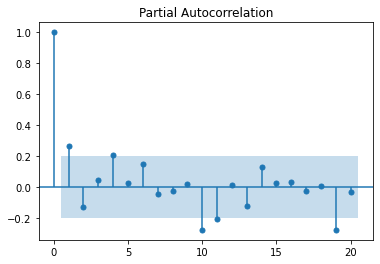

In [233]:
plot_pacf(temp_df['mood'].values)
plt.show()

## Temporal Models

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed

In [201]:
data_temporal_pre = data_pre.copy()
data_temporal_pre.reset_index(drop=False,inplace=True)
data_temporal_pre.set_index(['Id','Date'],inplace=True)
#data_temporal_pre

### Univariate approach - ARIMA
Prediction by using mood only

In [51]:
univariate = data_temporal_pre.iloc[:,:2]
univariate

days_count  mood
Id      Date                        
AS14.01 2014-03-21        33.0  6.20
        2014-03-22        34.0  6.40
        2014-03-23        35.0  6.80
        2014-03-24        36.0  6.00
        2014-03-25        37.0  6.75
...                        ...   ...
AS14.33 2014-05-27       100.0  6.20
        2014-05-28       101.0  8.20
        2014-05-29       102.0  7.00
        2014-05-30       103.0  6.80
        2014-05-31       104.0  7.00

[1291 rows x 2 columns]

In [52]:
for i in all_ids:
        a = univariate.loc[i].index
        for j in np.arange(0,len(a)):
            univariate.loc[i,'days_count'][a[j]] = j+1

In [55]:
univariate.reset_index(drop=False,inplace=True)
#univariate.set_index(['Id','Date','days_count'],drop=True,inplace=True)

In [56]:
univariate

,Id,Date,days_count,mood
0,AS14.01,2014-03-21,1.0,6.20
1,AS14.01,2014-03-22,2.0,6.40
2,AS14.01,2014-03-23,3.0,6.80
3,AS14.01,2014-03-24,4.0,6.00
4,AS14.01,2014-03-25,5.0,6.75
...,...,...,...,...
1286,AS14.33,2014-05-27,42.0,6.20
1287,AS14.33,2014-05-28,43.0,8.20
1288,AS14.33,2014-05-29,44.0,7.00
1289,AS14.33,2014-05-30,45.0,6.80


In [235]:
store_models = []
testing = []

for i in all_ids:
    X = univariate[univariate.Id.values == i].iloc[:,range(3,len(univariate.columns))]    # create subset of data for each Id which is X
    
    arima_model = ARIMA(X, order=(2,1,2))
    model = arima_model.fit()
    store_models.append(model)
    x_test = np.array(X)
    testing.extend(x_test.tolist())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmode

In [236]:
forecast = []

for m in range(0,len(store_models)):
    f = store_models[m].predict()
    ff = np.array(f)
    forecast.extend(ff.tolist())

In [237]:
df_arima = pd.DataFrame()
df_arima['test'] = univariate['mood'].tolist()
df_arima['forecast'] = forecast
df_arima['test_shift'] = df_arima['test'].shift(periods=1)
df_arima

,test,forecast,test_shift
0,6.20,0.000000,NaN
1,6.40,6.199999,6.2
2,6.80,6.315172,6.4
3,6.00,6.561538,6.8
4,6.75,6.275480,6.0
...,...,...,...
1286,6.20,5.888111,5.4
1287,8.20,6.260657,6.2
1288,7.00,7.050163,8.2
1289,6.80,6.884799,7.0


In [238]:
list_drop = []
for i in range(0,int(len(df_arima))):
    if df_arima.iloc[i,1] <= 1.0:
        list_drop.append(i)

print(list_drop)

[0, 45, 86, 134, 187, 233, 281, 343, 389, 430, 483, 530, 586, 640, 697, 743, 790, 830, 886, 917, 986, 1029, 1068, 1112, 1159, 1203, 1245]


In [239]:
for i in list_drop:
    df_arima.drop([i],inplace=True)

In [240]:
df_arima

,test,forecast,test_shift
1,6.40,6.199999,6.20
2,6.80,6.315172,6.40
3,6.00,6.561538,6.80
4,6.75,6.275480,6.00
5,6.60,6.452751,6.75
...,...,...,...
1286,6.20,5.888111,5.40
1287,8.20,6.260657,6.20
1288,7.00,7.050163,8.20
1289,6.80,6.884799,7.00


In [241]:
print('MAE test:', metrics.mean_absolute_error(df_arima['test_shift'],df_arima['forecast']))
print('MSE test:', metrics.mean_squared_error(df_arima['test_shift'],df_arima['forecast']))

MAE test: 0.3233542336822117
MSE test: 0.20133432401524481


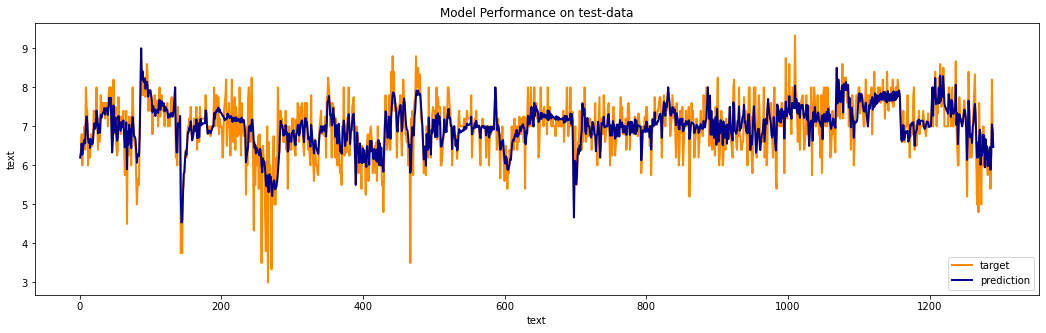

In [242]:
plt.figure(figsize = (18, 5))
plt.plot(df_arima['test_shift'],
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(df_arima['forecast'],
        color='darkblue',
        linewidth=2,
        label = 'prediction')
plt.xlabel('text')
plt.ylabel('text')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data')
plt.show()

### Univariate approach - RNN
only very bad results

### Multivariate approach - RNN

In [64]:
for i in all_ids:
        a = data_temporal_pre.loc[i].index
        for j in np.arange(0,len(a)):
            data_temporal_pre.loc[i,'days_count'][a[j]] = j+1

In [65]:
data_temporal_pre.reset_index(drop=False,inplace=True)
data_temporal_pre.set_index(['Id','Date','days_count'],drop=True,inplace=True)

In [68]:
data_temporal = data_temporal_pre.iloc[:,:-1]
#data_temporal

In [70]:
# data normalization
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
for i in all_ids:
        data_temporal.loc[i] = minmaxscaler.fit_transform(data_temporal.loc[i])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [71]:
data_temporal.reset_index(drop=False,inplace=True)
data_temporal.fillna(0,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [72]:
data_temporal

,Id,Date,days_count,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,...,circumplex.arousal_3dayavg,circumplex.valence_3dayavg,activity_3dayavg,screen_3dayavg,call_3dayavg,sms_3dayavg,appCat.communication_3dayavg,appCat.professional_3dayavg,appCat.recreation_3dayavg,appCat.convenience_3dayavg
0,AS14.01,2014-03-21,1.0,0.100000,0.707317,0.2,0.598239,0.795447,0.600000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,AS14.01,2014-03-22,2.0,0.200000,0.902439,0.5,0.752214,0.205989,0.300000,0.25,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,AS14.01,2014-03-23,3.0,0.400000,0.707317,0.8,0.393056,0.237446,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,AS14.01,2014-03-24,4.0,0.000000,1.000000,0.0,0.339465,0.649459,1.000000,0.00,...,0.875000,0.357143,1.000000,0.311291,0.692308,0.200000,0.462039,0.102445,0.291700,0.279064
4,AS14.01,2014-03-25,5.0,0.375000,0.853659,0.5,0.440944,0.969567,0.000000,0.25,...,1.000000,0.271429,0.780204,0.241765,1.000000,0.200000,0.581174,0.036362,0.197169,0.116464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,AS14.33,2014-05-27,42.0,0.388889,0.500000,0.5,0.032044,0.147409,0.032258,0.50,...,0.250000,0.252381,0.213392,0.555737,0.222222,0.444444,0.515011,0.267239,0.520409,0.336540
1287,AS14.33,2014-05-28,43.0,0.944444,0.714286,0.9,0.297294,0.614773,0.322581,0.25,...,0.289474,0.295238,0.211606,0.415273,0.240741,0.666667,0.490676,0.267239,0.332533,0.413792
1288,AS14.33,2014-05-29,44.0,0.611111,0.238095,0.8,0.490686,0.123630,0.161290,0.25,...,0.486842,0.542857,0.153531,0.559736,0.388889,0.666667,0.539091,1.000000,0.449045,1.000000
1289,AS14.33,2014-05-30,45.0,0.555556,0.428571,0.1,0.489029,0.394443,0.129032,0.00,...,0.241228,0.828571,0.274278,0.241847,0.296296,0.444444,0.434089,0.732761,0.280923,0.751569


In [73]:
window = 5
t_test = []
t_pred = []

for i in all_ids:
    X = data_temporal[data_temporal.Id.values == i].iloc[:,range(3,len(data_temporal.columns))]    # create subset of data for each Id which is X
    
    last = int(len(data_temporal[data_temporal.Id.values == i])/5)     
    X_train = X[:-last]                         # size of training set is 80% of subset (flexible for each Id) - first 80% in terms of rows
    X_test = X[-last-window:]                   # size of test set is 20% of subset (flexible for each Id) - last 20% in terms of rows
    in_train = []
    out_train = []
    for j in range(window,len(X_train)):
        in_train.append(np.array(X_train.iloc[j-window:j,:]))       # 5 days sequence of all variables e.g. in first iteration from row 0 to 4
        out_train.append(np.array(X_train.iloc[j,0]))               # mood value e.g. in first iteration of row 5 # mood is target in temporal dataset, no shift needed
     
    in_train, out_train = np.array(in_train), np.array(out_train)

    in_test = []
    out_test = []
    for j in range(window,len(X_test)):
        in_test.append(np.array(X_test.iloc[j-window:j,:]))           # same as with training subset
        out_test.append(np.array(X_test.iloc[j,0]))
     
    in_test, out_test = np.array(in_test), np.array(out_test)

    model = Sequential()

    model.add(LSTM(128, input_shape=(in_train.shape[1:]), activation='relu',return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(128, input_shape=(in_train.shape[1:]), activation='relu',return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, input_shape=([in_train.shape[0],128]), activation='sigmoid'))

    model.compile(loss='mse',optimizer='adam')
    model.fit(in_train, out_train, epochs=100,verbose=0,batch_size=1)

    t_test.extend(out_test.tolist())
    predictions = model.predict(in_test)
    for pred in range(len(predictions)):
        t_pred.append(predictions.tolist()[pred][0])


In [80]:
mulit_test = np.array(t_test)
mulit_predict = np.array(t_pred)

In [81]:
print('MAE test:', metrics.mean_absolute_error(mulit_test,mulit_predict))
print('MSE test:', metrics.mean_squared_error(mulit_test,mulit_predict))

MAE test: 0.22865510406004896
MSE test: 0.09418199883265128


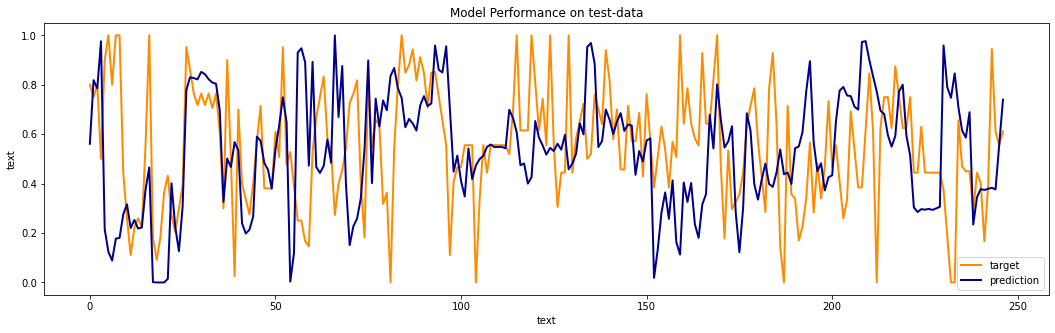

In [76]:
plt.figure(figsize = (18, 5))
plt.plot(np.array(mulit_test),
        color='darkorange',
        linewidth=2,
        label = 'target')
plt.plot(np.array(mulit_predict),
        color='darkblue',
        linewidth=2,
        label = 'prediction')
plt.xlabel('text')
plt.ylabel('text')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data')
plt.show()